In [8]:
import torch
import torch.nn.functional as F
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def ctc_decode(log_probs, voc, blank_index=0):
    """
    Decodificar las probabilidades de salida de la RNN para obtener la secuencia de texto.

    log_probs: Salida logarítmica del modelo RNN después de aplicar softmax (T, N, C)
    voc: El vocabulario usado para el mapeo de caracteres
    blank_index: Índice usado para el carácter en blanco en CTC
    """
    # Obtener los índices con la mayor probabilidad en cada timestep
    max_probs = torch.argmax(log_probs, dim=-1)
    
    decoded_batch = []
    for sequence in max_probs.permute(1, 0):  # Cambiar a (N, T)
        decoded_sequence = []
        previous_char = None
        for index in sequence:
            if index != blank_index:  # Ignorar el carácter en blanco
                char = voc[index] if index < len(voc) else ''
                if char != previous_char:  # Eliminar duplicados consecutivos
                    decoded_sequence.append(char)
                previous_char = char
        decoded_sequence = ''.join(decoded_sequence)  # Unir los caracteres
        decoded_batch.append(decoded_sequence)
    return decoded_batch

In [9]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            # Entrada: [batch_size, 1, 32, 128]
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Salida: [batch_size, 32, 32, 128]
            nn.SELU(),
            nn.MaxPool2d(2, 2),  # Salida: [batch_size, 32, 16, 64]
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Salida: [batch_size, 64, 16, 64]
            nn.SELU(),
            nn.MaxPool2d(2, 2),  # Salida: [batch_size, 64, 8, 32]
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Salida: [batch_size, 128, 8, 32]
            nn.SELU(),
            nn.MaxPool2d((2, 1)),  # Salida: [batch_size, 128, 4, 32]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Salida: [batch_size, 256, 4, 32]
            nn.SELU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2, 1)),  # Salida: [batch_size, 256, 2, 32]

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Salida: [batch_size, 512, 2, 32]
            nn.SELU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((2, 1)),  # Salida: [batch_size, 512, 1, 32]
        )
        
        self.rnn = nn.LSTM(512, 128, bidirectional=True, batch_first=True, num_layers=2)  # Entrada: [batch_size, 31, 512], Salida: [batch_size, 31, 256]
        self.fc = nn.Linear(256, num_classes)  # Entrada: [batch_size, 31, 256], Salida: [batch_size, 31, num_classes]
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, nonlinearity='selu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='selu')
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        init.kaiming_normal_(param, nonlinearity='selu')
                    elif 'bias' in name:
                        init.constant_(param, 0)

    def forward(self, x):
        # x inicial: [batch_size, 1, 32, 128]
        x = self.cnn(x)
        # Salida: [batch_size, 512, 1, 31]
        x = x.squeeze(2)  # Remover la dimensión 2 que es 1, resultado: [batch_size, 512, 31]
        x = x.permute(0, 2, 1)  # Reorganizar a [batch_size, 31, 512]
        
        x, _ = self.rnn(x)
        # Salida esperada: [batch_size, 31, 256]
        
        x = self.fc(x)
        # Salida esperada: [batch_size, 31, num_classes]
        
        return x 

In [12]:
def load_image(image_path):
    """Carga la imagen desde el path especificado y la convierte a formato PIL"""
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None

def preprocess_image(image, transform):
    """Aplica las transformaciones a la imagen"""
    return transform(image)

def infer_text_from_image(model, image, transform, voc):
    """Recibe una imagen, aplica las transformaciones y devuelve el texto predicho por el modelo"""
    # Preprocesar la imagen
    image = preprocess_image(image, transform)
    
    # Convertir la imagen a un batch de un solo elemento
    image = image.unsqueeze(0).to(device)
    
    # Inferencia
    model.eval()
    with torch.no_grad():
        logits = model(image)
        
        # Aplicar log_softmax y reordenar las dimensiones
        log_probs = F.log_softmax(logits, dim=2).permute(1, 0, 2)
        
        # Decodificar las probabilidades para obtener el texto
        pred_texts = ctc_decode(log_probs, voc)
        
    return pred_texts[0]

# Definir las transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((32, 128)),  # Cambiar tamaño de la imagen
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizar con media y desviación estándar 0.5
])

# Configurar el vocabulario
voc = '0123456789abcdefghijklmnopqrstuvwxyz'

# Ruta de la imagen de prueba
image_path = '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_0.jpg'

# Cargar y procesar la imagen
image = load_image(image_path)

# Cargar el modelo y moverlo al dispositivo
model = CRNN(len(voc) + 1).to(device)
model.load_state_dict(torch.load("model_epoch_24.pth", map_location=device))

if image is not None:
    # Obtener el texto predicho
    predicted_text = infer_text_from_image(model, image, transform, voc)
    print("Predicted text:", predicted_text)

Predicted text: kils


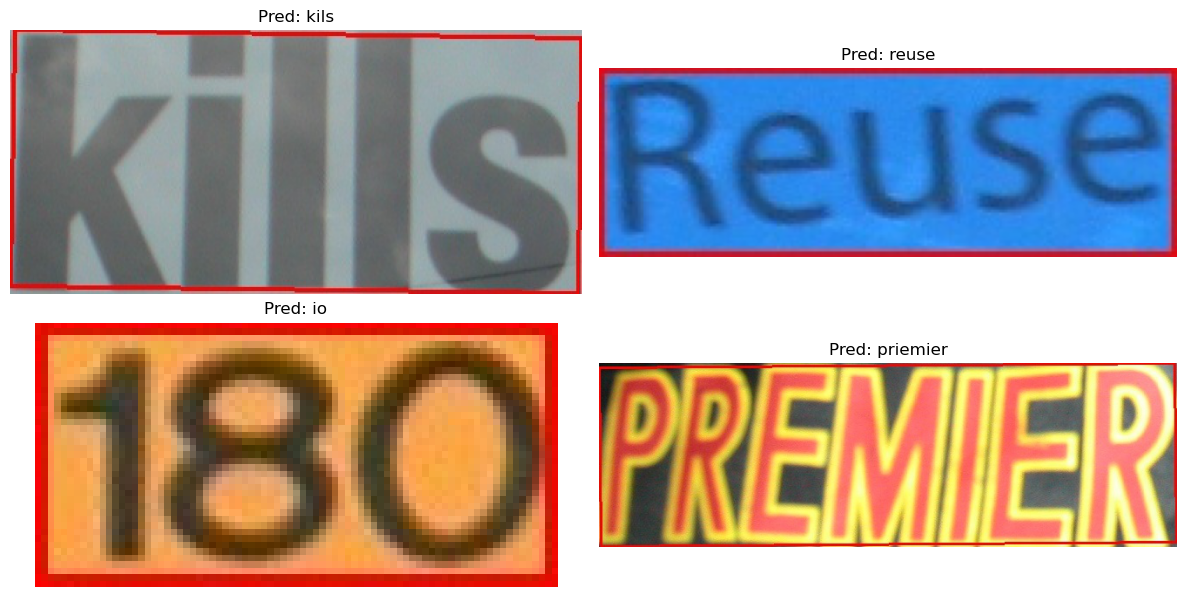

In [16]:
# Rutas de las imágenes de prueba
image_paths = ['/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_0.jpg', '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_000.jpg', 
               '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_00.jpg', '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_00000.jpg']


# Inicializar listas para almacenar imágenes y predicciones
images = []
predictions = []

# Cargar y procesar las imágenes, y obtener las predicciones
for image_path in image_paths:
    image = load_image(image_path)
    if image is not None:
        predicted_text = infer_text_from_image(model, image, transform, voc)
        images.append(image)
        predictions.append(predicted_text)

# Ploteo de las imágenes con sus predicciones
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

for img, pred, ax in zip(images, predictions, axes):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Pred: {pred}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
image_paths = ['/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_0.jpg', '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_000.jpg', 
               '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_00.jpg', '/home/xnmaster/deep-learning-project-2024-ai_nndl_group_01_/recognition/resultres_img_00000.jpg']
